In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
alpha = 2.0
beta = 0
mu = 0
c = 1
rv = 10
grid_size = 400
num_steps = 100000
num_runs = 300
num_targets = 60
first_passage_times = []


'''# Zolotarev's equation to sample from the Lévy alpha-stable distribution
def levy_alpha_stable(alpha, beta, mu, c):
    theta = torch.rand(1, device=device) * np.pi - np.pi / 2
    W = torch.distributions.Exponential(1).sample().to(device)
    numerator = torch.sin(alpha * theta)
    denominator = torch.cos(theta).pow(1 / alpha)
    correction_factor = (torch.cos((1 - alpha) * theta) / W).pow((1 - alpha) / alpha)
    step_length = numerator / denominator * correction_factor
    return c * step_length + mu

def random_direction():
    angle = torch.rand(1, device=device) * 2 * np.pi
    return torch.tensor([torch.cos(angle), torch.sin(angle)], device=device).flatten()

def distance(walker_position, target_position):
    return torch.norm(walker_position - target_position)'''


# Parameters
alpha = 2.0
beta = 0
mu = 0
c = 1
rv = 5
grid_size = 400
num_steps = 100000
num_runs = 200
num_targets = 50
first_passage_times = []


# Zolotarev's equation to sample from the Lévy alpha-stable distribution
def levy_alpha_stable(alpha, beta, mu, c):
    theta = torch.rand(1, device=device) * np.pi - np.pi / 2
    W = torch.distributions.Exponential(1).sample().to(device)
    numerator = torch.sin(alpha * theta)
    denominator = torch.cos(theta).pow(1 / alpha)
    correction_factor = (torch.cos((1 - alpha) * theta) / W).pow((1 - alpha) / alpha)
    step_length = numerator / denominator * correction_factor
    return c * step_length + mu

def random_direction():
    angle = torch.rand(1, device=device) * 2 * np.pi
    return torch.tensor([torch.cos(angle), torch.sin(angle)], device=device).flatten()

def distance(walker_position, target_position):
    return torch.norm(walker_position - target_position)



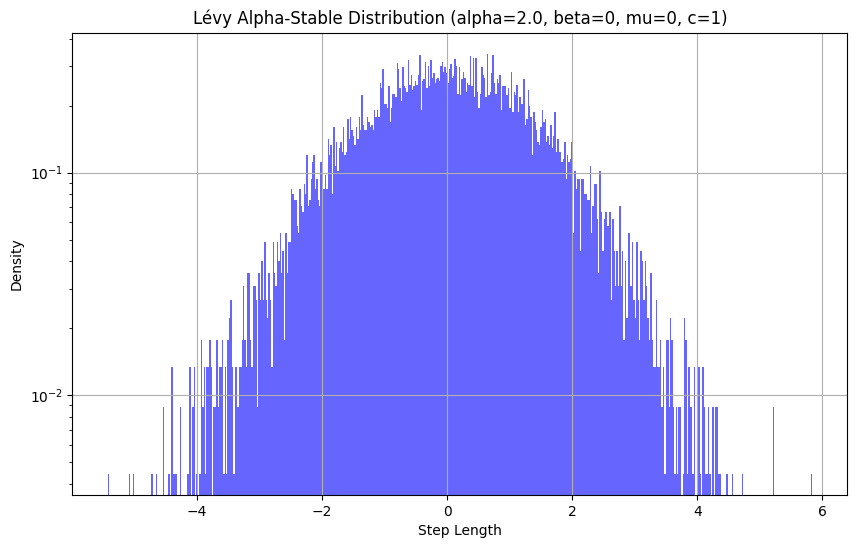

In [33]:

num_samples = 10000
step_lengths = []

for _ in range(num_samples):
    step_length = levy_alpha_stable(alpha, beta, mu, c)
    step_lengths.append(step_length.item())

step_lengths = np.array(step_lengths)

plt.figure(figsize=(10, 6))
plt.hist(step_lengths, bins=500, density=True, alpha=0.6, color='blue')
plt.title(f'Lévy Alpha-Stable Distribution (alpha={alpha}, beta={beta}, mu={mu}, c={c})')
plt.xlabel('Step Length')
plt.ylabel('Density')
plt.yscale('log')
plt.grid(True)
plt.show()


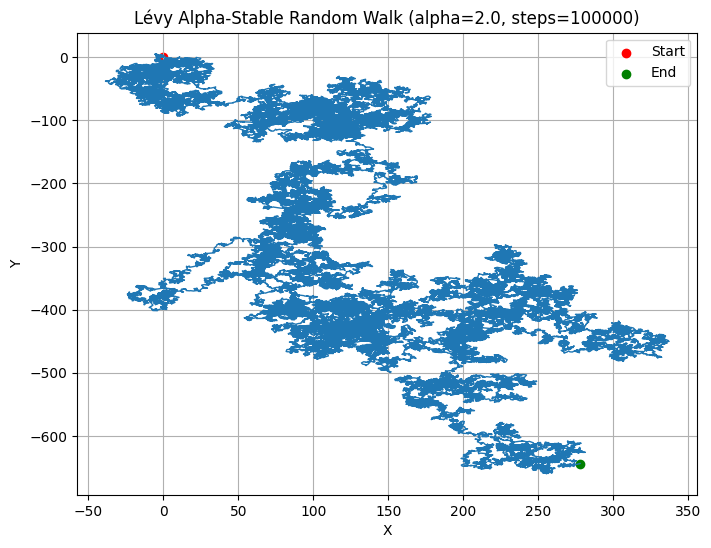

In [34]:

def simulate_levy_walk(n_steps, alpha, beta, mu, c):
    positions = [torch.zeros(2, device=device)]
    for _ in range(n_steps):
        step = levy_alpha_stable(alpha, beta, mu, c)
        angle = torch.rand(1, device=device) * 2 * np.pi
        step_vector = torch.tensor([torch.cos(angle), torch.sin(angle)], device=device) * step
        new_position = positions[-1] + step_vector
        positions.append(new_position)

    return torch.stack(positions).cpu().numpy()


alpha = 2.0
beta = 0
mu = 0
c = 1
n_steps = 100000


trajectory = simulate_levy_walk(n_steps, alpha, beta, mu, c)


plt.figure(figsize=(8, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], lw=1)
plt.scatter(trajectory[0, 0], trajectory[0, 1], color='red', label='Start')
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='green', label='End')
plt.title(f"Lévy Alpha-Stable Random Walk (alpha={alpha}, steps={n_steps})")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


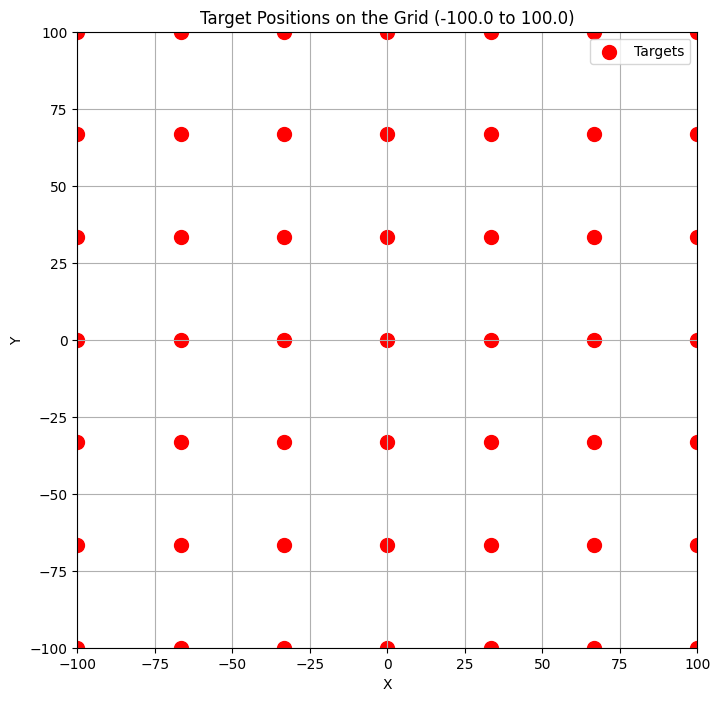

In [11]:

def place_targets_lattice(grid_size, num_targets):
    target_positions = []

    grid_points_per_axis = int(np.sqrt(num_targets))
    step = grid_size / (grid_points_per_axis - 1)
    start = -grid_size / 2
    for x in np.linspace(start, grid_size / 2, grid_points_per_axis):
        for y in np.linspace(start, grid_size / 2, grid_points_per_axis):
            target_positions.append((x, y))
            if len(target_positions) == num_targets:
                return torch.tensor(target_positions, device=device, dtype=torch.float32)

    return torch.tensor(target_positions, device=device, dtype=torch.float32)


def visualize_targets(target_positions, grid_size):
    target_positions = target_positions.cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.scatter(target_positions[:, 0], target_positions[:, 1], color='red', label='Targets', s=100)
    plt.title(f'Target Positions on the Grid (-{grid_size / 2} to {grid_size / 2})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-grid_size / 2, grid_size / 2)
    plt.ylim(-grid_size / 2, grid_size / 2)
    plt.grid(True)
    plt.legend()
    plt.show()


grid_size = 400
num_targets = 60
target_positions = place_targets_lattice(grid_size=grid_size, num_targets=num_targets)
visualize_targets(target_positions, grid_size)


In [35]:

for run in range(num_runs):
    target_positions = place_targets_lattice(grid_size, num_targets)
    walker_position = torch.tensor([(torch.rand(1, device=device) - 0.5) * grid_size/2,
                                    (torch.rand(1, device=device) - 0.5) * grid_size/2], device=device).flatten()

    walker_path = [walker_position.clone().cpu().numpy()]

    depletion_time_limit = 180
    start_time = time.time()

    step_count = 0
    found_target = False

    external_travel_distance = 60

    while True:
        
        elapsed_time = time.time() - start_time
        if elapsed_time > depletion_time_limit:
            print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
            break


        step_length = levy_alpha_stable(alpha, beta, mu, c).abs()  
        #print(f"New step length: {step_length.item()}")
        increment_size = step_length.item() / 10
        #print(f"Increment size: {increment_size}")
        #print(run)

        direction = random_direction()

        distance_traveled = 0

        while distance_traveled < step_length.item():

            walker_position += increment_size * direction
            distance_traveled += increment_size
            #print(distance_traveled)
            step_count += 1  

            walker_position = torch.clamp(walker_position, -grid_size/2, grid_size/2)


            walker_path.append(walker_position.clone().cpu().numpy())


            for target in target_positions:
                dister=distance(walker_position, target).item()

                if distance(walker_position, target).item() <= rv:
                    print(dister)
                    first_passage_times.append(step_count)
                    found_target = True
                    print(f"Target found at step {step_count}!")
                    break


            if found_target:
                break


            elapsed_time = time.time() - start_time
            if elapsed_time > depletion_time_limit:
                print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
                break

            if distance_traveled >= external_travel_distance:
                print(f"External travel distance of {external_travel_distance} exceeded. Changing direction.")
                break


        if found_target or elapsed_time > depletion_time_limit:
            print(f"Run {run + 1}: Target found at step {step_count}" if found_target else "Depletion time exceeded.")
            break

    walker_path = np.array(walker_path)

    plt.figure(figsize=(16, 16))
    plt.plot(walker_path[:, 0], walker_path[:, 1], label="Walker's Path", color='blue')
    plt.scatter(target_positions[:, 0].cpu().numpy(), target_positions[:, 1].cpu().numpy(), color='red', label='Targets', s=20)
    plt.scatter(grid_size // 2, grid_size // 2, color='green', label='Start Position', s=50)
    plt.title(f'Run {run + 1} - Walker Trajectory and Targets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-grid_size/2, grid_size/2)
    plt.ylim(-grid_size/2, grid_size/2)

    plt.grid(True)
    plt.legend()


    plt.savefig(f'walker_trajectory_run_last{run + 1}.png')
    plt.close()


4.83398962020874
Target found at step 11816!
Run 1: Target found at step 11816
4.875787734985352
Target found at step 13555!
Run 2: Target found at step 13555
4.974025249481201
Target found at step 12912!
Run 3: Target found at step 12912
4.918153762817383
Target found at step 1672!
Run 4: Target found at step 1672
4.997990608215332
Target found at step 5897!
Run 5: Target found at step 5897
4.910661220550537
Target found at step 10587!
Run 6: Target found at step 10587
4.967715740203857
Target found at step 94086!
Run 7: Target found at step 94086
4.947051048278809
Target found at step 4684!
Run 8: Target found at step 4684
4.992839813232422
Target found at step 4214!
Run 9: Target found at step 4214
4.808900356292725
Target found at step 313!
Run 10: Target found at step 313
4.803290367126465
Target found at step 5667!
Run 11: Target found at step 5667
4.976190567016602
Target found at step 9490!
Run 12: Target found at step 9490
4.889721870422363
Target found at step 70426!
Run 13: 

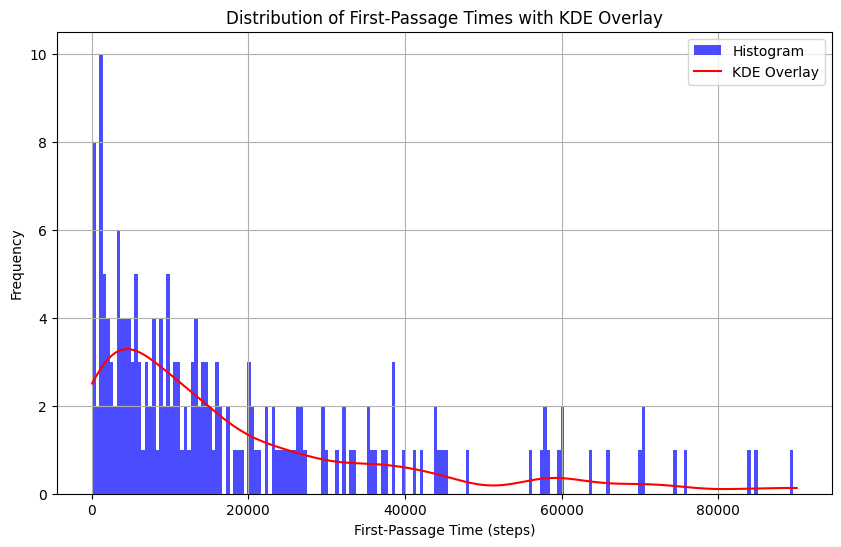

In [53]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

min_steps = 60
max_steps = 90000
bins = 200

plt.figure(figsize=(10, 6))
hist_data = plt.hist(first_passage_times, bins=bins, range=(min_steps, max_steps), color='blue', alpha=0.7, label="Histogram")

kde = gaussian_kde(first_passage_times, bw_method=0.2)  # Adjust `bw_method` to smoothen or sharpen the KDE line
x_values = np.linspace(min_steps, max_steps, 1000)
kde_values = kde(x_values) * len(first_passage_times) * (max_steps - min_steps) / bins

plt.plot(x_values, kde_values, color='red', linewidth=1.5, label="KDE Overlay")

plt.title("Distribution of First-Passage Times with KDE Overlay")
plt.xlabel("First-Passage Time (steps)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
import numpy as np

first_passage_times = np.array(first_passage_times)  

zero_indices = np.where(first_passage_times == 0)[0]

print("Indices of zero values:", zero_indices)
print("Number of zero values:", len(zero_indices))


Indices of zero values: []
Number of zero values: 0


In [38]:
len(first_passage_times)

200

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

np.random.seed(42)

# Simulation parameters
L = 100              # Size of the 2D area (L x L)
num_targets = 30    # Number of targets
rv = 5            # Detection radius
mu = 1.5              # Lévy exponent (1 < mu <= 3)
max_steps = 100000     # Maximum number of steps for the forager
max_time = 100000     # Maximum time allowed for the simulation
num_runs = 100   # Number of simulation runs

# Generate uniformly distributed targets (same for all runs)
targets_x = np.random.uniform(0, L, num_targets)
targets_y = np.random.uniform(0, L, num_targets)
targets = np.vstack((targets_x, targets_y)).T

# Create a KDTree for efficient nearest neighbor search (same for all runs)
tree = KDTree(targets)

# Initialize variables to collect aggregated data over all runs
all_first_passage_times = []
all_return_times = []
all_unique_traps_visited = []
all_mean_traps_visited = []
all_trap_visit_times = []

# Function to generate Lévy flight step lengths using Zolotarev's formula
def generate_levy_flight_zolotarev(mu, size=1):
    # Zolotarev's method for generating symmetric alpha-stable variables
    # Reference: Weron, A., & Weron, R. (1995). Computer simulation of Lévy α-stable variables.
    # Note: For 1 < mu <= 2 (Lévy flights), where mu is the stability parameter alpha
    phi = np.pi * (np.random.uniform(-0.5, 0.5, size))  # phi ~ Uniform(-pi/2, pi/2)
    w = np.random.exponential(scale=1.0, size=size)  # w ~ Exponential(1)
    # Parameters for Zolotarev's formula
    alpha = mu
    beta = 0  # Symmetric distribution
    cos_phi = np.cos(phi)
    sin_alpha_phi = np.sin(alpha * phi)
    cos_phi_to_1_over_alpha = cos_phi ** (1 / alpha)
    exponent = (np.cos((1 - alpha) * phi) / w) ** ((1 - alpha) / alpha)
    step_lengths = sin_alpha_phi / cos_phi_to_1_over_alpha * exponent
    return np.abs(step_lengths)

# Run the simulation multiple times
for run in range(num_runs):
    # Initialize forager's position at a random location
    forager_pos = np.random.uniform(0, L, 2)
    
    # Initialize variables for each run
    positions = [forager_pos.copy()]
    times = [0]
    trap_visits = []
    first_passage_time = None
    return_times = []
    visited_traps = {}  # Dictionary to store last visit time to each trap
    
    # Simulation loop
    step = 0
    time = 0
    
    while step < max_steps and time < max_time:
        # Search for targets within detection radius rv
        indices = tree.query_ball_point(forager_pos, rv)
        
        if indices:
            # Targets are within detection radius
            # Find the actual nearest target among those within rv
            targets_in_range = targets[indices]
            distances = np.linalg.norm(targets_in_range - forager_pos, axis=1)
            min_idx = np.argmin(distances)
            nearest_index = indices[min_idx]
            nearest_target = targets[nearest_index]
            distance = distances[min_idx]
            
            # Update time (assuming constant speed, set speed = 1)
            time += distance  # Speed is 1 unit distance per unit time
            
            # Move to the target
            forager_pos = nearest_target.copy()
            positions.append(forager_pos.copy())
            times.append(time)
            
            # Record trap visit
            trap_visits.append(nearest_index)
            
            if first_passage_time is None:
                # Record first passage time only once per run
                first_passage_time = time
            else:
                # Return time to this trap
                if nearest_index in visited_traps:
                    last_visit_time = visited_traps[nearest_index]
                    return_times.append(time - last_visit_time)
            visited_traps[nearest_index] = time
        else:
            # No targets within detection radius
            # Perform a Lévy flight using Zolotarev's formula
            l_j = generate_levy_flight_zolotarev(mu)[0]
            
            # Ensure l_j is less than L
            l_j = min(l_j, L)
            
            # Choose a random direction
            theta = np.random.uniform(0, 2 * np.pi)
            
            # Move incrementally towards the new point, constantly searching for targets
            num_steps_incremental = int(l_j)  # Number of incremental steps
            if num_steps_incremental == 0:
                num_steps_incremental = 1
            step_size = l_j / num_steps_incremental
            for _ in range(num_steps_incremental):
                # Move a small step
                dx = step_size * np.cos(theta)
                dy = step_size * np.sin(theta)
                forager_pos[0] += dx
                forager_pos[1] += dy
                
                # Reflective boundary conditions
                for i in [0,1]:
                    if forager_pos[i] < 0:
                        forager_pos[i] = -forager_pos[i]
                        # Reflect the direction
                        if i == 0:
                            theta = np.pi - theta
                        else:
                            theta = -theta
                    elif forager_pos[i] > L:
                        forager_pos[i] = 2*L - forager_pos[i]
                        # Reflect the direction
                        if i == 0:
                            theta = np.pi - theta
                        else:
                            theta = -theta
                positions.append(forager_pos.copy())
                
                # Update time
                time += step_size  # Assuming speed is 1 unit distance per unit time
                times.append(time)
                
                # Check for targets within detection radius
                indices = tree.query_ball_point(forager_pos, rv)
                if indices:
                    # Targets are within detection radius
                    # Find the actual nearest target among those within rv
                    targets_in_range = targets[indices]
                    distances = np.linalg.norm(targets_in_range - forager_pos, axis=1)
                    min_idx = np.argmin(distances)
                    nearest_index = indices[min_idx]
                    nearest_target = targets[nearest_index]
                    distance_to_target = distances[min_idx]
                    
                    # Update time
                    time += distance_to_target
                    # Move to the target
                    forager_pos = nearest_target.copy()
                    positions.append(forager_pos.copy())
                    times.append(time)
                    
                    # Record trap visit
                    trap_visits.append(nearest_index)
                    
                    if first_passage_time is None:
                        # Record first passage time only once per run
                        first_passage_time = time
                    else:
                        # Return time to this trap
                        if nearest_index in visited_traps:
                            last_visit_time = visited_traps[nearest_index]
                            return_times.append(time - last_visit_time)
                    visited_traps[nearest_index] = time
                    break  # Exit the incremental movement loop
        step += 1
    
    # After the simulation of one run, collect data for analysis
    positions = np.array(positions)
    times = np.array(times)
    
    # Calculate mean number of traps visited over time
    unique_traps_visited = len(set(trap_visits))
    mean_traps_visited = unique_traps_visited / time
    
    # Aggregate data over all runs
    if first_passage_time is not None:
        all_first_passage_times.append(first_passage_time)
    all_return_times.extend(return_times)
    all_unique_traps_visited.append(unique_traps_visited)
    all_mean_traps_visited.append(mean_traps_visited)
    all_trap_visit_times.append(list(visited_traps.values()))


# Plotting the aggregated results

# 1. Trajectory of the forager (from the last run)
plt.figure(figsize=(8, 8))
plt.plot(positions[:, 0], positions[:, 1], '-o', markersize=2, linewidth=0.5)
plt.scatter(targets_x, targets_y, c='red', s=10, label='Targets')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Forager Trajectory (Last Run)')
plt.legend()
plt.xlim(0, L)
plt.ylim(0, L)
plt.grid(True)
plt.show()

# 2. Aggregated Distribution of First Passage Times
plt.figure()
plt.hist(all_first_passage_times, bins=50, density=True, alpha=0.7)
plt.xlabel('First Passage Time')
plt.ylabel('Probability Density')
plt.title('Aggregated Distribution of First Passage Times')
plt.grid(True)
plt.show()

# 3. Aggregated Distribution of Return Times
plt.figure()
plt.hist(all_return_times, bins=50, density=True, alpha=0.7)
plt.xlabel('Return Time')
plt.ylabel('Probability Density')
plt.title('Aggregated Distribution of Return Times')
plt.grid(True)
plt.show()

# 4. Mean number of traps visited over all runs
mean_unique_traps_visited = np.mean(all_unique_traps_visited)
mean_of_mean_traps_visited = np.mean(all_mean_traps_visited)

print(f"Average unique traps visited over {num_runs} runs: {mean_unique_traps_visited}")
print(f"Average mean number of traps visited per unit time over {num_runs} runs: {mean_of_mean_traps_visited}")
# 5. Aggregated Cumulative Number of Unique Traps Visited Over Time
# Combine all trap visit times from all runs
all_trap_visit_times_flat = [t for t_list in all_trap_visit_times for t in t_list]
# Sort all trap visit times
sorted_trap_visit_times = np.sort(all_trap_visit_times_flat)
# Create cumulative counts
cumulative_traps = np.arange(1, len(sorted_trap_visit_times) + 1)
# Plot cumulative number of unique traps visited over time
plt.figure()
plt.plot(sorted_trap_visit_times, cumulative_traps, '-o')
plt.xlabel('Time')
plt.ylabel('Cumulative Unique Traps Visited')
plt.title('Cumulative Number of Unique Traps Visited Over Time (Aggregated)')
plt.grid(True)
plt.show()



In [ ]:
'''# Main simulation loop
for run in range(num_runs):
    target_positions = place_targets_lattice(grid_size, num_targets)  # Assuming you have this function
    walker_position = torch.tensor([(torch.rand(1, device=device) - 0.5) * grid_size / 2,
                                    (torch.rand(1, device=device) - 0.5) * grid_size / 2], device=device).flatten()

    walker_path = [walker_position.clone().cpu().numpy()]

    depletion_time_limit = 120
    start_time = time.time()

    step_count = 0
    found_target = False

    # External travel distance condition
    external_travel_distance = 30  # Can be adjusted as needed

    while True:
        # Check if depletion time has been exceeded
        elapsed_time = time.time() - start_time
        if elapsed_time > depletion_time_limit:
            print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
            break

        # Select a distance l_j from the Lévy alpha-stable distribution
        step_length = levy_alpha_stable(alpha, beta, mu, c).abs()  # Ensure step length is positive
        increment_size = step_length.item() / 10
        direction = random_direction()

        # Track the total distance traveled in this step
        distance_traveled = 0

        # Move incrementally towards the destination in steps of size `increment_size`
        while distance_traveled < step_length.item():
            # Move by a small increment towards the destination
            walker_position += increment_size * direction
            distance_traveled += increment_size
            step_count += 1  # Increment total step count

            # Ensure the walker stays within bounds
            walker_position = torch.clamp(walker_position, -grid_size / 2, grid_size / 2)

            # Print for debugging: walker position and distance to each target
            print(f"Walker position: {walker_position}")

            # Check if a target is within the detection radius
            for target in target_positions:
                dist = distance(walker_position, target).item()  # Get the distance to the target
                print(f"Distance to target: {dist}")

                if dist <= rv:
                    # Record the first passage time
                    first_passage_times.append(step_count)
                    found_target = True
                    print(f"Target found at step {step_count}!")
                    break

            # If a target is found, exit the loop
            if found_target:
                break

            # Check if real-world time has been exhausted
            elapsed_time = time.time() - start_time
            if elapsed_time > depletion_time_limit:
                print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
                break

            # Check if external travel distance condition is met
            if distance_traveled >= external_travel_distance:
                print(f"External travel distance of {external_travel_distance} exceeded. Changing direction.")
                break

        # If a target is found or depletion time is exceeded, exit the loop
        if found_target or elapsed_time > depletion_time_limit:
            print(f"Run {run + 1}: Target found at step {step_count}" if found_target else "Depletion time exceeded.")
            break

    # Plot the walker's trajectory and target points on the grid
    walker_path = np.array(walker_path)

    plt.figure(figsize=(16, 16))
    plt.plot(walker_path[:, 0], walker_path[:, 1], label="Walker's Path", color='blue')
    plt.scatter(target_positions[:, 0].cpu().numpy(), target_positions[:, 1].cpu().numpy(), color='red', label='Targets', s=20)
    plt.scatter(grid_size // 2, grid_size // 2, color='green', label='Start Position', s=50)
    plt.title(f'Run {run + 1} - Walker Trajectory and Targets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-grid_size / 2, grid_size / 2)
    plt.ylim(-grid_size / 2, grid_size / 2)

    plt.grid(True)
    plt.legend()

    # Save the plot for each run
    plt.savefig(f'walker_trajectory_run_last{run + 1}.png')
    plt.close()
'''

In [ ]:
'''import time

# Main simulation loop
for run in range(num_runs):

    target_positions = place_targets_lattice(grid_size, num_targets)

    walker_position = torch.tensor([(torch.rand(1, device=device) - 0.5) * grid_size,
                                (torch.rand(1, device=device) - 0.5) * grid_size], device=device).flatten()

    walker_path = [walker_position.clone().cpu().numpy()]

    depletion_time_limit = 120
    start_time = time.time()

    step_count = 0
    found_target = False

    while True:
        # Check if depletion time has been exceeded
        elapsed_time = time.time() - start_time
        if elapsed_time > depletion_time_limit:
            print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
            break

        # Select a distance l_j from the Lévy alpha-stable distribution
        step_length = levy_alpha_stable(alpha, beta, mu, c)
        print(f"New step length: {step_length.item()}")

        # Select a random direction
        direction = random_direction()

        # Track the number of incremental steps taken for this step length
        steps_for_current_length = 0  # Initialize step counter for current step length

        # Move incrementally towards the destination in steps of size `increment_size`
        while True:
            # Move by a small increment towards the destination
            walker_position += increment_size * direction
            steps_for_current_length += 1  # Increment step count for current step length
            step_count += 1  # Total step count

            # Ensure the walker stays within bounds
            walker_position = torch.clamp(walker_position, -grid_size, grid_size)


            # Append position to path
            walker_path.append(walker_position.clone().cpu().numpy())

            # Check if a target is within the detection radius
            for target in target_positions:
                if distance(walker_position, target) <= rv:
                    # Record the first passage time
                    first_passage_times.append(step_count)
                    found_target = True
                    print(f"Target found at step {step_count}!")
                    break

            # If a target is found, exit the loop
            if found_target:
                break
            print(steps_for_current_length)
            # Check if the journey for this step length is done (steps_for_current_length exceeds num_steps)
            if steps_for_current_length >= num_steps:
                # Generate a new step length and direction without breaking the loop
                steps_for_current_length = 0  # Reset step count for new step length
                step_length = levy_alpha_stable(alpha, beta, mu, c)
                direction = random_direction()
                print(f"New step length after {num_steps} steps: {step_length.item()}")
            print(steps_for_current_length)
            # Check if real-world time has been exhausted
            elapsed_time = time.time() - start_time
            print(elapsed_time)
            if elapsed_time > depletion_time_limit:
                print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
                break

        # If a target is found or depletion time is exceeded, exit the loop
        if found_target or elapsed_time > depletion_time_limit:
            print(f"Run {run+1}: Target found at step {step_count}" if found_target else "Depletion time exceeded.")
            break

    # If no target was found within the depletion time, record the max step count
    if not found_target:
        print('No target found within depletion time.')

    # Plot the walker's trajectory and target points on the grid
    walker_path = np.array(walker_path)

    plt.figure(figsize=(16, 16))
    plt.plot(walker_path[:, 0], walker_path[:, 1], label="Walker's Path", color='blue')
    plt.scatter(target_positions[:, 0].cpu().numpy(), target_positions[:, 1].cpu().numpy(), color='red', label='Targets', s=20)
    plt.scatter(grid_size // 2, grid_size // 2, color='green', label='Start Position', s=50)
    plt.title(f'Run {run+1} - Walker Trajectory and Targets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-grid_size, grid_size)
    plt.ylim(-grid_size, grid_size)

    plt.grid(True)
    plt.legend()

    # Save the plot for each run
    plt.savefig(f'walker_trajectory_run_{run+1}.png')
    plt.close()
'''

In [ ]:
'''# Main simulation loop
for run in range(num_runs):
    target_positions = place_targets_lattice(grid_size, num_targets)
    walker_position = torch.tensor([(torch.rand(1, device=device) - 0.5) * grid_size,
                                    (torch.rand(1, device=device) - 0.5) * grid_size], device=device).flatten()

    walker_path = [walker_position.clone().cpu().numpy()]

    depletion_time_limit = 120
    start_time = time.time()

    step_count = 0
    found_target = False
    fixed_travel_limit = 10  # Fixed limit for travel in one direction (set to 10 units)

    while True:
        # Check if depletion time has been exceeded
        elapsed_time = time.time() - start_time
        if elapsed_time > depletion_time_limit:
            print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
            break

        # Select a distance l_j from the Lévy alpha-stable distribution
        step_length = levy_alpha_stable(alpha, beta, mu, c).item()  # New step length
        print(f"New step length from Lévy: {step_length}")

        increment_size = step_length / 10 # Define the increment size per step
        direction = random_direction()  # Select a random direction

        # Track cumulative distance traveled for this leg of the journey
        cumulative_distance = 0

        # Move incrementally, but stop after fixed_travel_limit if no target is found
        while cumulative_distance < fixed_travel_limit:
            # Move by a small increment towards the destination
            walker_position += increment_size * direction
            step_count += 1  # Total step count
            cumulative_distance += increment_size  # Accumulate the distance traveled

            # Ensure the walker stays within bounds
            walker_position = torch.clamp(walker_position, -grid_size, grid_size)

            # Append position to path for visualization
            walker_path.append(walker_position.clone().cpu().numpy())

            # Check if a target is within the detection radius
            for target in target_positions:
                if distance(walker_position, target) <= rv:
                    # Record the first passage time
                    first_passage_times.append(step_count)
                    found_target = True
                    print(f"Target found at step {step_count}!")
                    break

            # If a target is found, stop moving in the current direction
            if found_target:
                break

        # If no target was found after traveling the fixed distance, change direction
        if cumulative_distance >= fixed_travel_limit and not found_target:
            print(f"Traveled {fixed_travel_limit} units without finding a target. Changing direction and step length.")
            continue  # A new step length and direction will be chosen in the next iteration

        # If a target is found or the depletion time is exceeded, exit the loop
        if found_target or elapsed_time > depletion_time_limit:
            print(f"Run {run + 1}: Target found at step {step_count}" if found_target else "Depletion time exceeded.")
            break

    # Plot the walker's trajectory and target points on the grid
    walker_path = np.array(walker_path)

    plt.figure(figsize=(16, 16))
    plt.plot(walker_path[:, 0], walker_path[:, 1], label="Walker's Path", color='blue')
    plt.scatter(target_positions[:, 0].cpu().numpy(), target_positions[:, 1].cpu().numpy(), color='red', label='Targets', s=20)
    plt.scatter(grid_size // 2, grid_size // 2, color='green', label='Start Position', s=50)
    plt.title(f'Run {run + 1} - Walker Trajectory and Targets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-grid_size, grid_size)
    plt.ylim(-grid_size, grid_size)

    plt.grid(True)
    plt.legend()

    # Save the plot for each run
    plt.savefig(f'walker_trajectory_run_{run + 1}.png')
    plt.close()
'''

In [ ]:
'''import numpy as np
import torch
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
alpha = 1.5
beta = 0
mu = 0
c = 1
rv = 1
grid_size = 400
num_steps = 100
num_runs = 200
num_targets = 40  # Number of targets
first_passage_times = []


# Zolotarev's equation to sample from the Lévy alpha-stable distribution
def levy_alpha_stable(alpha, beta, mu, c):
    theta = torch.rand(1, device=device) * np.pi - np.pi / 2
    W = torch.distributions.Exponential(1).sample().to(device)
    numerator = torch.sin(alpha * theta)
    denominator = torch.cos(theta).pow(1 / alpha)
    correction_factor = (torch.cos((1 - alpha) * theta) / W).pow((1 - alpha) / alpha)
    step_length = numerator / denominator * correction_factor
    return c * step_length + mu

# Function to generate a random direction in 2D space
def random_direction():
    angle = torch.rand(1, device=device) * 2 * np.pi
    return torch.tensor([torch.cos(angle), torch.sin(angle)], device=device).flatten()

# Function to calculate the Euclidean distance
def distance(walker_position, target_position):
    return torch.norm(walker_position - target_position)

# Main simulation loop
for run in range(num_runs):
    target_positions = place_targets_lattice(grid_size, num_targets)
    walker_position = torch.tensor([(torch.rand(1, device=device) - 0.5) * grid_size,
                                    (torch.rand(1, device=device) - 0.5) * grid_size], device=device).flatten()

    walker_path = [walker_position.clone().cpu().numpy()]

    depletion_time_limit = 120
    start_time = time.time()

    step_count = 0
    found_target = False

    while True:
        # Check if depletion time has been exceeded
        elapsed_time = time.time() - start_time
        if elapsed_time > depletion_time_limit:
            print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
            break

        # Select a distance l_j from the Lévy alpha-stable distribution
        step_length = levy_alpha_stable(alpha, beta, mu, c)
        print(f"New step length: {step_length.item()}")
        increment_size = step_length.item() / 10
        print(increment_size)
        # Select a random direction
        direction = random_direction()

        # Track the number of incremental steps taken for this step length
        steps_for_current_length = 0  # Initialize step counter for current step length

        # Move incrementally towards the destination in steps of size `increment_size`
        while True:
            # Move by a small increment towards the destination
            walker_position += increment_size * direction
            steps_for_current_length += 1  # Increment step count for current step length
            step_count += 1  # Total step count

            # Ensure the walker stays within bounds
            walker_position = torch.clamp(walker_position, -grid_size, grid_size)

            # Append position to path
            walker_path.append(walker_position.clone().cpu().numpy())

            # Check if a target is within the detection radius
            for target in target_positions:
                if distance(walker_position, target) <= rv:
                    # Record the first passage time
                    first_passage_times.append(step_count)
                    found_target = True
                    print(f"Target found at step {step_count}!")
                    break

            # If a target is found, exit the loop
            if found_target:
                break

            # Check if the journey for this step length is done (steps_for_current_length exceeds num_steps)
            if steps_for_current_length >= num_steps:
                # Generate a new step length and direction without breaking the loop
                steps_for_current_length = 0  # Reset step count for new step length
                step_length = levy_alpha_stable(alpha, beta, mu, c)
                direction = random_direction()
                increment_size = step_length.item() /100
                print(f"New step length after {num_steps} steps: {step_length.item()}")

            # Check if real-world time has been exhausted
            elapsed_time = time.time() - start_time
            if elapsed_time > depletion_time_limit:
                print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
                break

        # If a target is found or depletion time is exceeded, exit the loop
        if found_target or elapsed_time > depletion_time_limit:
            print(f"Run {run + 1}: Target found at step {step_count}" if found_target else "Depletion time exceeded.")
            break

    # Plot the walker's trajectory and target points on the grid
    walker_path = np.array(walker_path)

    plt.figure(figsize=(16, 16))
    plt.plot(walker_path[:, 0], walker_path[:, 1], label="Walker's Path", color='blue')
    plt.scatter(target_positions[:, 0].cpu().numpy(), target_positions[:, 1].cpu().numpy(), color='red', label='Targets', s=20)
    plt.scatter(grid_size // 2, grid_size // 2, color='green', label='Start Position', s=50)
    plt.title(f'Run {run + 1} - Walker Trajectory and Targets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-grid_size, grid_size)
    plt.ylim(-grid_size, grid_size)

    plt.grid(True)
    plt.legend()

    # Save the plot for each run
    plt.savefig(f'walker_trajectory_run_{run + 1}.png')
    plt.close()
'''

In [ ]:
'''# Main simulation loop for multiple runs
for run in range(num_runs):
    # Place targets on lattice points in the grid
    target_positions = place_targets_lattice(grid_size, num_targets)

    # Random walker starts at a random position in the grid
    walker_position = torch.tensor([torch.rand(1, device=device) * grid_size,
                                    torch.rand(1, device=device) * grid_size], device=device).flatten()

    # Store walker's path for plotting
    walker_path = [walker_position.clone().cpu().numpy()]

    # Simulation loop for a single run
    step_count = 0  # Step counter for first passage time
    found_target = False  # Initialize the found_target flag before the loop

    while step_count < num_steps:  # Maximum of 1000 steps
        # Select a distance l_j from the Lévy alpha-stable distribution
        step_length = levy_alpha_stable(alpha, beta, mu, c)

        # Select a random direction
        direction = random_direction()

        # Calculate the destination point after moving the full step length
        destination = walker_position + step_length * direction

        # Move incrementally towards the destination in steps of size `increment_size`
        while torch.norm(walker_position - destination) > increment_size and step_count < num_steps:
            # Move by a small increment towards the destination
            walker_position += increment_size * direction

            # Ensure the walker stays within bounds
            walker_position = torch.clamp(walker_position, 0, grid_size)

            # Increment step counter
            step_count += 1

            # Append position to path
            walker_path.append(walker_position.clone().cpu().numpy())

            # Check if a target is within the detection radius
            for target in target_positions:
                if distance(walker_position, target) <= rv:
                    # Record the first passage time
                    first_passage_times.append(step_count)
                    found_target = True
                    print("yay")
                    break  # Break out of the inner loop

            # Break if a target is found or the step limit is reached
            print(step_count)
            if step_count>num_steps:
              break
            if found_target or step_count >= num_steps:
                break
        if step_count>num_steps:
              break
        # Break the outer loop if a target was found
        if found_target:
            print(step_count)
            break

    # If no target was found within the max steps, record the max step count
    if not found_target:
        first_passage_times.append(num_steps)

    # Plot the walker's trajectory and target points on the grid
    walker_path = np.array(walker_path)

    plt.figure(figsize=(16, 16))
    plt.plot(walker_path[:, 0], walker_path[:, 1], label="Walker's Path", color='blue')
    plt.scatter(target_positions[:, 0].cpu().numpy(), target_positions[:, 1].cpu().numpy(), color='red', label='Targets', s=20)
    plt.scatter(grid_size // 2, grid_size // 2, color='green', label='Start Position', s=50)
    plt.title(f'Run {run+1} - Walker Trajectory and Targets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.grid(True)
    plt.legend()

    # Save the plot for each run
    plt.savefig(f'walker_trajectory_run_{run+1}.png')
    plt.close()
'''
'''import time

# Main simulation loop for multiple runs
for run in range(num_runs):
    # Place targets on lattice points in the grid
    target_positions = place_targets_lattice(grid_size, num_targets)

    # Random walker starts at a random position in the grid
    walker_position = torch.tensor([(torch.rand(1, device=device) - 0.5) * grid_size,
                                (torch.rand(1, device=device) - 0.5) * grid_size], device=device).flatten()

    # Store walker's path for plotting
    walker_path = [walker_position.clone().cpu().numpy()]

    # Set depletion time (e.g., 120 seconds)
    depletion_time_limit = 120  # seconds
    start_time = time.time()  # Record the start time

    step_count = 0  # Step counter for first passage time
    found_target = False  # Initialize the found_target flag before the loop

    while True:
        # Check if depletion time has been exceeded
        elapsed_time = time.time() - start_time
        if elapsed_time > depletion_time_limit:
            print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
            break

        # Select a distance l_j from the Lévy alpha-stable distribution
        step_length = levy_alpha_stable(alpha, beta, mu, c)
        print(f"New step length: {step_length.item()}")

        # Select a random direction
        direction = random_direction()

        # Track the number of incremental steps taken for this step length
        steps_for_current_length = 0  # Initialize step counter for current step length

        # Move incrementally towards the destination in steps of size `increment_size`
        while True:
            # Move by a small increment towards the destination
            walker_position += increment_size * direction
            steps_for_current_length += 1  # Increment step count for current step length
            step_count += 1  # Total step count

            # Ensure the walker stays within bounds
            walker_position = torch.clamp(walker_position, -grid_size, grid_size)  # Extend clamping to -grid_size to grid_size

            # Append position to path
            walker_path.append(walker_position.clone().cpu().numpy())

            # Check if a target is within the detection radius
            for target in target_positions:
                if distance(walker_position, target) <= rv:
                    # Record the first passage time
                    first_passage_times.append(step_count)
                    found_target = True
                    print(f"Target found at step {step_count}!")
                    break

            # If a target is found, exit the loop
            if found_target:
                break
            print(steps_for_current_length)
            # Check if the journey for this step length is done (steps_for_current_length exceeds num_steps)
            if steps_for_current_length >= num_steps:
                # Generate a new step length and direction without breaking the loop
                steps_for_current_length = 0  # Reset step count for new step length
                step_length = levy_alpha_stable(alpha, beta, mu, c)
                direction = random_direction()
                print(f"New step length after {num_steps} steps: {step_length.item()}")
            print(steps_for_current_length)
            # Check if real-world time has been exhausted
            elapsed_time = time.time() - start_time
            print(elapsed_time)
            if elapsed_time > depletion_time_limit:
                print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
                break

        # If a target is found or depletion time is exceeded, exit the loop
        if found_target or elapsed_time > depletion_time_limit:
            print(f"Run {run+1}: Target found at step {step_count}" if found_target else "Depletion time exceeded.")
            break

    # If no target was found within the depletion time, record the max step count
    if not found_target:
        print('No target found within depletion time.')

    # Plot the walker's trajectory and target points on the grid
    walker_path = np.array(walker_path)

    plt.figure(figsize=(16, 16))
    plt.plot(walker_path[:, 0], walker_path[:, 1], label="Walker's Path", color='blue')
    plt.scatter(target_positions[:, 0].cpu().numpy(), target_positions[:, 1].cpu().numpy(), color='red', label='Targets', s=20)
    plt.scatter(0, 0, color='green', label='Start Position', s=50)

    # Update the plotting limits to match the extended grid
    plt.title(f'Run {run+1} - Walker Trajectory and Targets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-grid_size, grid_size)  # Corrected to show -600 to 600
    plt.ylim(-grid_size, grid_size)  # Corrected to show -600 to 600
    plt.grid(True)
    plt.legend()

    # Save the plot for each run
    plt.savefig(f'walker_trajectory_run_{run+1}.png')
    plt.close()
'''
'''import time

# Main simulation loop for multiple runs
for run in range(num_runs):
    # Place targets on lattice points in the grid
    target_positions = place_targets_lattice(grid_size, num_targets)

    # Random walker starts at a random position in the grid
    walker_position = torch.tensor([torch.rand(1, device=device) * grid_size,
                                    torch.rand(1, device=device) * grid_size], device=device).flatten()

    # Store walker's path for plotting
    walker_path = [walker_position.clone().cpu().numpy()]

    # Set depletion time (e.g., 10 seconds)
    depletion_time_limit = 120  # seconds
    start_time = time.time()  # Record the start time

    step_count = 0  # Step counter for first passage time
    found_target = False  # Initialize the found_target flag before the loop

    while True:
        # Check if depletion time has been exceeded
        elapsed_time = time.time() - start_time
        if elapsed_time > depletion_time_limit:
            print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
            break

        # Select a distance l_j from the Lévy alpha-stable distribution
        step_length = levy_alpha_stable(alpha, beta, mu, c)
        print(f"New step length: {step_length.item()}")

        # Select a random direction
        direction = random_direction()

        # Calculate the destination point after moving the full step length
        destination = walker_position + step_length * direction

        # Track the number of incremental steps taken for this step length
        steps_for_current_length = 0  # Initialize step counter for current step length

        # Move incrementally towards the destination in steps of size `increment_size`
        while steps_for_current_length < num_steps:
            # Move by a small increment towards the destination
            walker_position += increment_size * direction
            print(steps_for_current_length)
            # Ensure the walker stays within bounds
            walker_position = torch.clamp(walker_position, 0, grid_size)

            # Check if real-world time has been exhausted
            elapsed_time = time.time() - start_time
            if elapsed_time > depletion_time_limit:
                print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
                break

            # Increment step counter
            step_count += 1
            steps_for_current_length += 1  # Increment step count for current step length
            print(f"Step {step_count}/{num_steps}")
            print(elapsed_time)
            # Append position to path
            walker_path.append(walker_position.clone().cpu().numpy())

            # Check if a target is within the detection radius
            for target in target_positions:
                if distance(walker_position, target) <= rv:
                    # Record the first passage time
                    first_passage_times.append(step_count)
                    found_target = True
                    print("Target found!")
                    break  # Break out of the inner loop

            # Break if a target is found
            if found_target:
                break

        # If a target is found or depletion time is exceeded, exit the loop
        if found_target or elapsed_time > depletion_time_limit:
            print(f"Run {run+1}: Target found at step {step_count}" if found_target else "Depletion time exceeded.")
            step_count=0
            break


    # If no target was found within the depletion time, record the max step count
    if not found_target:
        print('No target found within depletion time.')
        step_count=0

    # Plot the walker's trajectory and target points on the grid
    walker_path = np.array(walker_path)

    plt.figure(figsize=(16, 16))
    plt.plot(walker_path[:, 0], walker_path[:, 1], label="Walker's Path", color='blue')
    plt.scatter(target_positions[:, 0].cpu().numpy(), target_positions[:, 1].cpu().numpy(), color='red', label='Targets', s=20)
    plt.scatter(grid_size // 2, grid_size // 2, color='green', label='Start Position', s=50)
    plt.title(f'Run {run+1} - Walker Trajectory and Targets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.grid(True)
    plt.legend()

    # Save the plot for each run
    plt.savefig(f'walker_trajectory_run_{run+1}.png')
    plt.close()
'''
'''import time

# Main simulation loop for multiple runs
for run in range(num_runs):
    # Place targets on lattice points in the grid
    target_positions = place_targets_lattice(grid_size, num_targets)

    # Random walker starts at a random position in the grid
    walker_position = torch.tensor([torch.rand(1, device=device) * grid_size,
                                    torch.rand(1, device=device) * grid_size], device=device).flatten()

    # Store walker's path for plotting
    walker_path = [walker_position.clone().cpu().numpy()]

    # Set depletion time (e.g., 10 seconds)
    depletion_time_limit = 120  # seconds
    start_time = time.time()  # Record the start time

    step_count = 0  # Step counter for first passage time
    found_target = False  # Initialize the found_target flag before the loop

    while True:
        # Check if depletion time has been exceeded
        elapsed_time = time.time() - start_time
        if elapsed_time > depletion_time_limit:
            print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
            break

        # Select a distance l_j from the Lévy alpha-stable distribution
        step_length = levy_alpha_stable(alpha, beta, mu, c)
        print(step_count)
        # Select a random direction
        direction = random_direction()

        # Calculate the destination point after moving the full step length
        destination = walker_position + step_length * direction

        # Move incrementally towards the destination in steps of size increment_size
        while torch.norm(walker_position - destination) > increment_size:
            # Move by a small increment towards the destination
            if step_count <
            walker_position += increment_size * direction

            # Ensure the walker stays within bounds
            walker_position = torch.clamp(walker_position, 0, grid_size)

            # Check if real-world time has been exhausted
            elapsed_time = time.time() - start_time
            if elapsed_time > depletion_time_limit:
                print(f"Depletion time of {depletion_time_limit} seconds exceeded.")
                break

            # Increment step counter
            step_count += 1
            print(step_count)
            # Append position to path
            walker_path.append(walker_position.clone().cpu().numpy())

            # Check if a target is within the detection radius
            for target in target_positions:
                if distance(walker_position, target) <= rv:
                    # Record the first passage time
                    first_passage_times.append(step_count)
                    found_target = True
                    print("yay")
                    break  # Break out of the inner loop

            # Break if a target is found
            if found_target:
                break

        # If a target is found or depletion time is exceeded, exit the loop
        if found_target or elapsed_time > depletion_time_limit:
            print(f"Run {run+1}: Target found at step {step_count}" if found_target else "Depletion time exceeded.")
            break

    # If no target was found within the depletion time, record the max step count
    if not found_target:
        print('No Luck buddy')

    # Plot the walker's trajectory and target points on the grid
    walker_path = np.array(walker_path)

    plt.figure(figsize=(16, 16))
    plt.plot(walker_path[:, 0], walker_path[:, 1], label="Walker's Path", color='blue')
    plt.scatter(target_positions[:, 0].cpu().numpy(), target_positions[:, 1].cpu().numpy(), color='red', label='Targets', s=20)
    plt.scatter(grid_size // 2, grid_size // 2, color='green', label='Start Position', s=50)
    plt.title(f'Run {run+1} - Walker Trajectory and Targets')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.grid(True)
    plt.legend()

    # Save the plot for each run
    plt.savefig(f'walker_trajectory_run_{run+1}.png')
    plt.close()
'''

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the neural network
class ODE_Net(nn.Module):
    def __init__(self):
        super(ODE_Net, self).__init__()
        self.hidden1 = nn.Linear(4, 512)
        self.hidden2 = nn.Linear(512, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        return self.output(x)

# Loss function based on ODE residual
def loss_fn(x, psi_pred, psi_pred_deriv):
    f_x = torch.exp(-x / 5) * torch.cos(x) - psi_pred / 5
    residual = psi_pred_deriv - f_x
    return torch.mean(residual**2)

# Derivative of the network output with respect to x
def compute_derivative(net, x):
    x.requires_grad_(True)
    psi_pred = net(x)
    psi_pred_deriv = torch.autograd.grad(psi_pred, x, torch.ones_like(psi_pred), create_graph=True)[0]
    return psi_pred, psi_pred_deriv

# Training the neural network
def train(net, epochs=10000):
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Sample points x in [0, 1]
        x = torch.rand(100000, 4, device=device)

        # Compute the network prediction and its derivative
        psi_pred, psi_pred_deriv = compute_derivative(net, x)

        # Compute the loss
        loss = loss_fn(x, psi_pred, psi_pred_deriv)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if epoch % 100== 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Initialize the model and move it to GPU if available
net = ODE_Net().to(device)
train(net, epochs=6000)

# Solving the ODE using scipy's solve_ivp for an analytical solution
def ode_system(x, psi):
    return [np.exp(-x/5) * np.cos(x) - psi[0] / 5]

# Solve the ODE numerically
def analytical_solution(x_values):
    sol = solve_ivp(ode_system, [0, max(x_values)], [0], t_eval=x_values)
    return sol.y[0]

# Generate data points for comparison
x_values = np.linspace(1.1, 4, 10000)
x_values = x_values[:2048].reshape(4, 512)
analytical_values = analytical_solution(x_values)

# Convert x_values to tensor and get neural network approximation
x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1).to(device)
with torch.no_grad():
    nn_values = net(x_tensor).cpu().numpy()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_values, analytical_values, label='True (Numerical)', color='blue', linestyle='-')
plt.plot(x_values, nn_values, label='Neural network approximation', color='orange', linestyle='--')
plt.xlabel('x')
plt.ylabel(r'$\Psi(x)$')
plt.legend()
plt.title(r'Comparison of True vs Neural Network Approximation')
plt.grid(True)
plt.show()


In [ ]:
# Flatten x_values before converting to tensor
x_tensor = torch.tensor(x_values.flatten(), dtype=torch.float32).view(-1, 1).to(device)

# Pass through the network and reshape the result back to (4, 512)
with torch.no_grad():
    nn_values = net(x_tensor).cpu().numpy().reshape(4, 512)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_values.flatten(), analytical_values.flatten(), label='True (Numerical)', color='blue', linestyle='-')
plt.plot(x_values.flatten(), nn_values.flatten(), label='Neural network approximation', color='orange', linestyle='--')
plt.xlabel('x')
plt.ylabel(r'$\Psi(x)$')
plt.legend()
plt.title(r'Comparison of True vs Neural Network Approximation')
plt.grid(True)
